In [1]:
import pandas as pd
import numpy as np
import warnings
from ProcessPriceData import ProcessPriceData
from Backtester import Backtester
from StatisticalArbitrage import StatisticalArbitrage
from statsmodels.api import OLS
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

warnings.filterwarnings("ignore")

In [2]:
# Reading the data

df = pd.read_excel('Global Indices Data.xlsx')
df.set_index(df['date'], inplace=True)
df.drop(['date'], axis=1, inplace=True)
df = df[['ES(S&P)', 'Nifty 50 India']]
df.dropna(inplace=True)
df  

,ES(S&P),Nifty 50 India
date,,
2012-01-03,1252.549501,4617.823738
2012-01-04,1245.920306,4565.085764
2012-01-05,1241.009792,4564.844951
2012-01-06,1252.058449,4610.117733
2012-01-09,1250.830821,4567.012265
...,...,...
2022-09-14,4225.662218,10449.918600
2022-09-15,4241.988604,10398.816260
2022-09-16,4165.370539,10229.057500


In [3]:
df = ProcessPriceData(df)
dfn = df.normalize_prices()
dfn

,ES(S&P),Nifty 50 India
date,,
2012-01-03,1.000000,1.000000
2012-01-04,0.994707,0.988579
2012-01-05,0.990787,0.988527
2012-01-06,0.999608,0.998331
2012-01-09,0.998628,0.988997
...,...,...
2022-09-14,3.373649,2.262953
2022-09-15,3.386683,2.251887
2022-09-16,3.325514,2.215125


In [4]:
look_back = 5
timeperiod = 10
nbdevup, nbdevdn=1.5, 1.5
long_target, short_target = 1,1

In [5]:
# Initializing Parameters

inst1_n = dfn['Nifty 50 India']
inst2_n = dfn['ES(S&P)']
model = 0
datetime = []
equity = []
look_back = 5
timeperiod = 10
nbdevup, nbdevdn=1.5, 1.5
long_target, short_target = 1,1
position = 0
signal = ''
capital = 10000000
sprd = pd.DataFrame(columns = ['Spread', 'Margin'])
qty = []
trade_type = []
entry= []
exit = []
entry_price= []
exit_price = []

In [6]:
# Running the backtest

for i in range(0, len(dfn)):
    
    if i== 0:
        equity.append(capital)
        datetime.append(dfn.index[i])
        model = OLS([1,1], [1,1])
        model = model.fit()
        
    statarb = StatisticalArbitrage(inst1_n, inst2_n)
        
    val, model = statarb.calculate_hedge_ratio(i, look_back, model)         
    margin = statarb.spread_margin(hedge_ratio = model.params[0])
    
    sprd.loc[len(sprd)] = [val, margin]
    
    if len(sprd) < timeperiod:
        continue
        
    bb = statarb.bollinger_bands_on_spread(sprd, timeperiod, nbdevup, nbdevdn, long_target, short_target)
    
    # Generating Signals
        
    signal = statarb.bollinger_signals(bb)
        
    # Executing Trades
    
    backtest = Backtester(dfn, prices=sprd['Spread'], margins=sprd['Margin'])
        
    position, qty, equity, datetime, trade_type, entry, exit, entry_price, exit_price = backtest.execute_trades(datetime=datetime,
                                                                                                                i=i,
                                                                                                                capital=capital,
                                                                                                                signal=signal,
                                                                                                                position=position,
                                                                                                                qty=qty,
                                                                                                                equity=equity,
                                                                                                                trade_type=trade_type,
                                                                                                                entry=entry,
                                                                                                                exit=exit,
                                                                                                                entry_price=entry_price,
                                                                                                                exit_price=exit_price)

In [7]:
trade_log = backtest.create_trade_log(qty, trade_type, entry, exit, entry_price, exit_price)
trade_log

,Entry Date,Entry Price,Quantity,Exit Date,Exit Price,Trade Type
0,2012-01-16,-0.010445,1787139.0,2012-01-18,0.013643,Long
1,2012-01-19,0.021560,1794832.0,2012-02-13,-0.001760,Short
2,2012-02-15,0.022733,1740118.0,2012-02-22,-0.007818,Short
3,2012-02-27,-0.043372,1734148.0,2012-03-09,-0.002683,Long
4,2012-03-12,0.008751,1792089.0,2012-03-20,-0.040974,Short
...,...,...,...,...,...,...
175,2022-04-25,0.077819,10766393.0,2022-05-04,-0.028916,Short
176,2022-05-05,-0.073940,10840053.0,2022-05-24,0.048778,Long
177,2022-05-30,-0.055561,11103777.0,2022-06-15,0.084122,Long
178,2022-06-27,-0.059676,11379708.0,2022-07-04,0.029507,Long


In [8]:
accuracy, long_accuracy, short_accuracy = backtest.calculate_accuracy(trade_log)
accuracy, long_accuracy, short_accuracy 

(1.0, 1.0, 1.0)

,Strategy
CAGR,16.36
MAX DD,-3.79
Sharpe Ratio,1.80
Sortino Ratio,2.60
Calmar Ratio,4.32


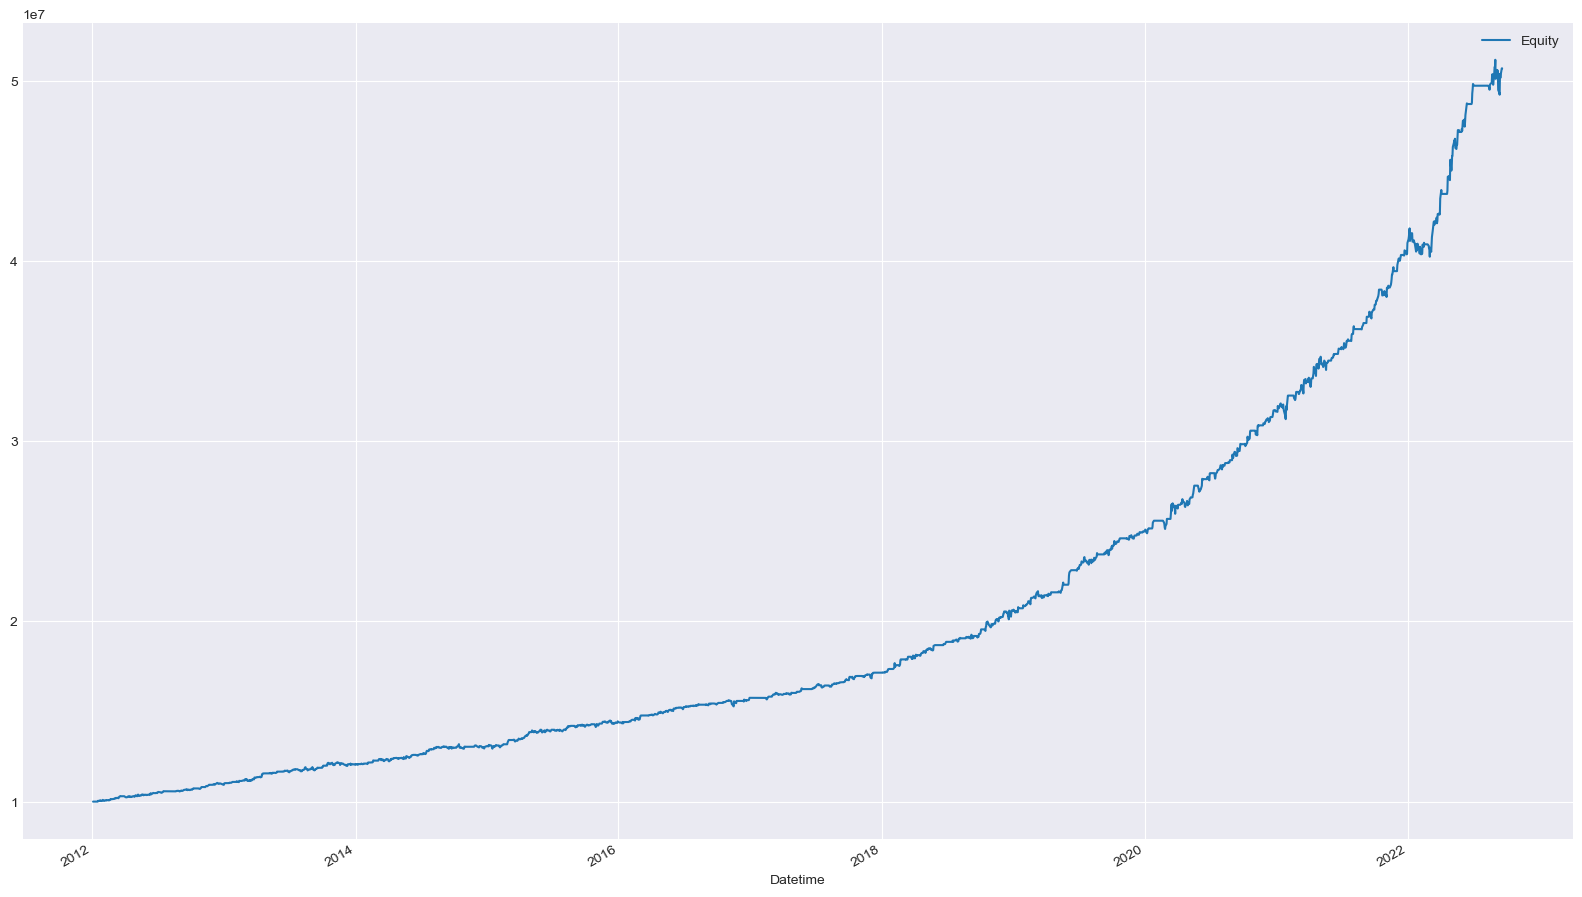

In [9]:
account, results = backtest.calculate_backtest_results(datetime, equity)
results

<AxesSubplot:>

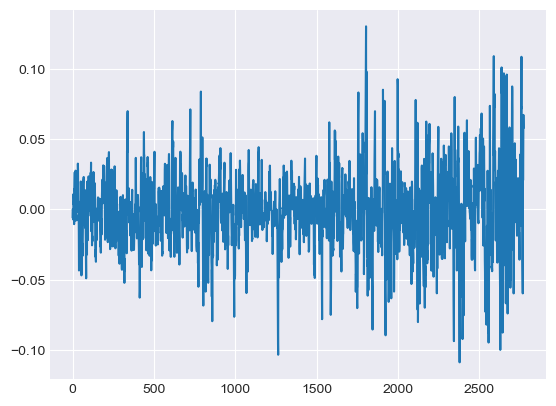

In [10]:
sprd.Spread.plot()